# INTRODUCTION

This is a step by step approach to the Predictive Insights competition.

# EXPLORATORY DATA ANALYSIS

## LOAD LIBRARIES

In [27]:
#necessary packages
!pip install xgboost

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,accuracy_score
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## LOAD DATA

In [28]:
data1 = pd.read_excel("2022 data.xlsx")
data2 = pd.read_csv("files_breakdown 2022.csv")
data3 = pd.read_csv("total_files_for_the_year.csv")
data4 = pd.read_csv("file_ageing.csv")



# EXPLORE FILES_BREAKDOWN 2022.CSV FILE

In [29]:
data2

,thisDate,branch name,new files,existing files,Total files
0,1/1/2022,BEITBRIDGE,2,0,2
1,1/2/2022,BEITBRIDGE,2,1,3
2,1/3/2022,BEITBRIDGE,2,0,2
3,1/4/2022,BEITBRIDGE,1,2,3
4,1/5/2022,BEITBRIDGE,2,2,4
...,...,...,...,...,...
6323,12/25/2022,ZVISHAVANE,3,4,7
6324,12/27/2022,ZVISHAVANE,2,0,2
6325,12/28/2022,ZVISHAVANE,1,2,3
6326,12/29/2022,ZVISHAVANE,2,1,3


In [30]:
rows,cols=data2.shape
print(f"The dataset has {rows} records and {cols} columns ".format(rows,cols))
print("\n\n STATISTICAL DESCRIPTION")
print(data2.describe())
columns=data2.columns
print("\n",columns)

The dataset has 6328 records and 5 columns 


 STATISTICAL DESCRIPTION
         new files  existing files  Total files
count  6328.000000     6328.000000  6328.000000
mean      3.631321        3.726612     7.357933
std       2.921687        4.699085     6.998998
min       1.000000        0.000000     1.000000
25%       2.000000        1.000000     3.000000
50%       3.000000        2.000000     5.000000
75%       5.000000        4.000000     9.000000
max      21.000000       29.000000    40.000000

 Index(['thisDate', 'branch name', 'new files', 'existing files',
       'Total files'],
      dtype='object')


From the above stats, it is found that there are 6328 total records with no null values as indicated by 6328/6328 values in all COLUMNS. The average number of new files received per day is around 3 and the most number of new files received per day is 5 files per day.The finding is validating the fact that the consultants work on 6 files per day,this is shown above with the average number of files received per day being 7.Moreover, 50% of the TOTAL FILES being 5 files per day,75% being 9 files per day and 25% of the files received per day were 3. It is also possible to receive more files as expected as shown above that there is a branch which received 40 files.It is said that the organization's working model is that the consultant has to work on 6 files per day that is four existing and two new files,the dataset is validating this as 75% of the existing files received per day is 4 files per day,however,the dataset shows that 25% of the new files received per day is 2 files  per day and 75% of the new files received per day is 5 files per day.

In [31]:
# Set the parsing of the datetime column so as to use some of the `dt` features in pandas later
data2["thisDate"]=pd.to_datetime(data2.loc[:, "thisDate"])

#change the branch name column to category Dtype
data2["branch name"] = data2["branch name"].astype("category")
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6328 entries, 0 to 6327
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   thisDate        6328 non-null   datetime64[ns]
 1   branch name     6328 non-null   category      
 2   new files       6328 non-null   int64         
 3   existing files  6328 non-null   int64         
 4   Total files     6328 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(3)
memory usage: 205.3 KB


It is clear that the dataset has no missing variables

In [32]:
#parse the date column to get important features for the model like week of the year
data2['month'] = pd.to_datetime(data2['thisDate']).dt.month
data2['day'] = pd.to_datetime(data2['thisDate']).dt.day
data2['week of year'] = pd.to_datetime(data2['thisDate']).dt.weekofyear
data2['quarter'] = pd.to_datetime(data2['thisDate']).dt.quarter

data2

<ipython-input-32-349a60f1105f>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data2['week of year'] = pd.to_datetime(data2['thisDate']).dt.weekofyear


,thisDate,branch name,new files,existing files,Total files,month,day,week of year,quarter
0,2022-01-01,BEITBRIDGE,2,0,2,1,1,52,1
1,2022-01-02,BEITBRIDGE,2,1,3,1,2,52,1
2,2022-01-03,BEITBRIDGE,2,0,2,1,3,1,1
3,2022-01-04,BEITBRIDGE,1,2,3,1,4,1,1
4,2022-01-05,BEITBRIDGE,2,2,4,1,5,1,1
...,...,...,...,...,...,...,...,...,...
6323,2022-12-25,ZVISHAVANE,3,4,7,12,25,51,4
6324,2022-12-27,ZVISHAVANE,2,0,2,12,27,52,4
6325,2022-12-28,ZVISHAVANE,1,2,3,12,28,52,4
6326,2022-12-29,ZVISHAVANE,2,1,3,12,29,52,4


In [68]:
#group the data with necessary features for the model
data=data2.groupby(["month","week of year","quarter","branch name"])[["Total files"]].sum()

data

Total files
month week of year quarter branch name                 
1     1            1       BEITBRIDGE                14
                           BULAWAYO                 200
                           CHEGUTU                    5
                           CHINHOYI BRANCH           24
                           CHIREDZI                  15
...                                                 ...
12    52           4       RUSAPE                    17
                           TURF                       3
                           VICTORIA FALLS             1
                           WILLOWVALE                76
                           ZVISHAVANE                13

[67392 rows x 1 columns]

Text(0, 0.5, 'TOTAL FILES PER QUARTER')

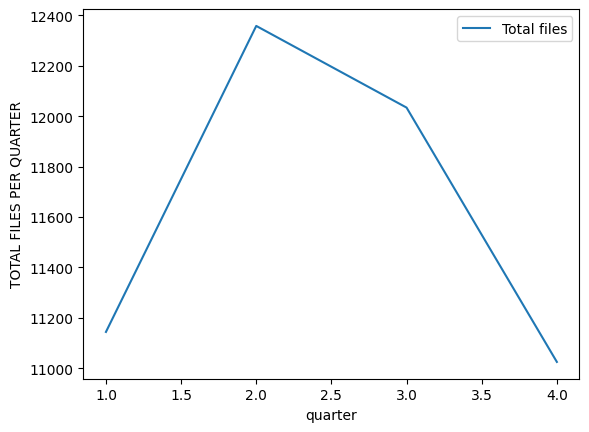

In [87]:
#group the dataset by quarter to visualize the total files received per season
gby_q=data2.groupby("quarter")[["Total files"]].sum()
gby_q=gby_q.reset_index()
gby_q.plot(x="quarter",y="Total files")
plt.ylabel("TOTAL FILES PER QUARTER")

- We can see that the number of files received during the first quarter are low
- moving from the first quarter to the second quarter we see a sharp increase in the number of files received.
- it is seen that there is a sharp decrease in the number of files from the second quarter to the third quarter
- the number of files received further decrease from the third quarter to the fourth quarter.

Text(0, 0.5, 'TOTAL FILES PER MONTH')

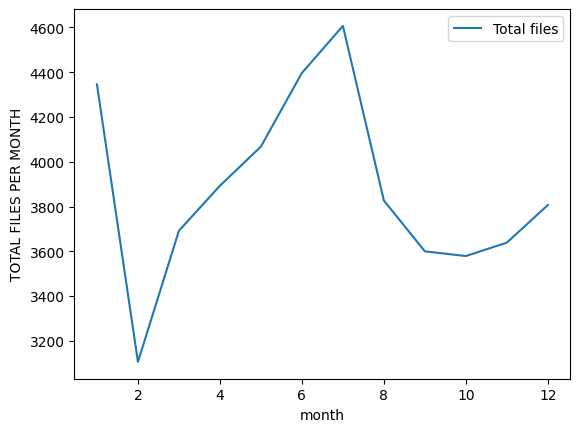

In [88]:
gby_m=data2.groupby("month")[["Total files"]].sum()
gby_m=gby_m.reset_index()
gby_m.plot(x="month",y="Total files")
plt.ylabel("TOTAL FILES PER MONTH")

- We can see from the above diagram that there is a sharp increase in the number of files received from February to July
- There is a decrease in the number of files received from July to October then a slight increase again from October to December.

In [69]:
#restore columns lost during grouping
data=data.reset_index()
datac=data

datac

,month,week of year,quarter,branch name,Total files
0,1,1,1,BEITBRIDGE,14
1,1,1,1,BULAWAYO,200
2,1,1,1,CHEGUTU,5
3,1,1,1,CHINHOYI BRANCH,24
4,1,1,1,CHIREDZI,15
...,...,...,...,...,...
67387,12,52,4,RUSAPE,17
67388,12,52,4,TURF,3
67389,12,52,4,VICTORIA FALLS,1
67390,12,52,4,WILLOWVALE,76


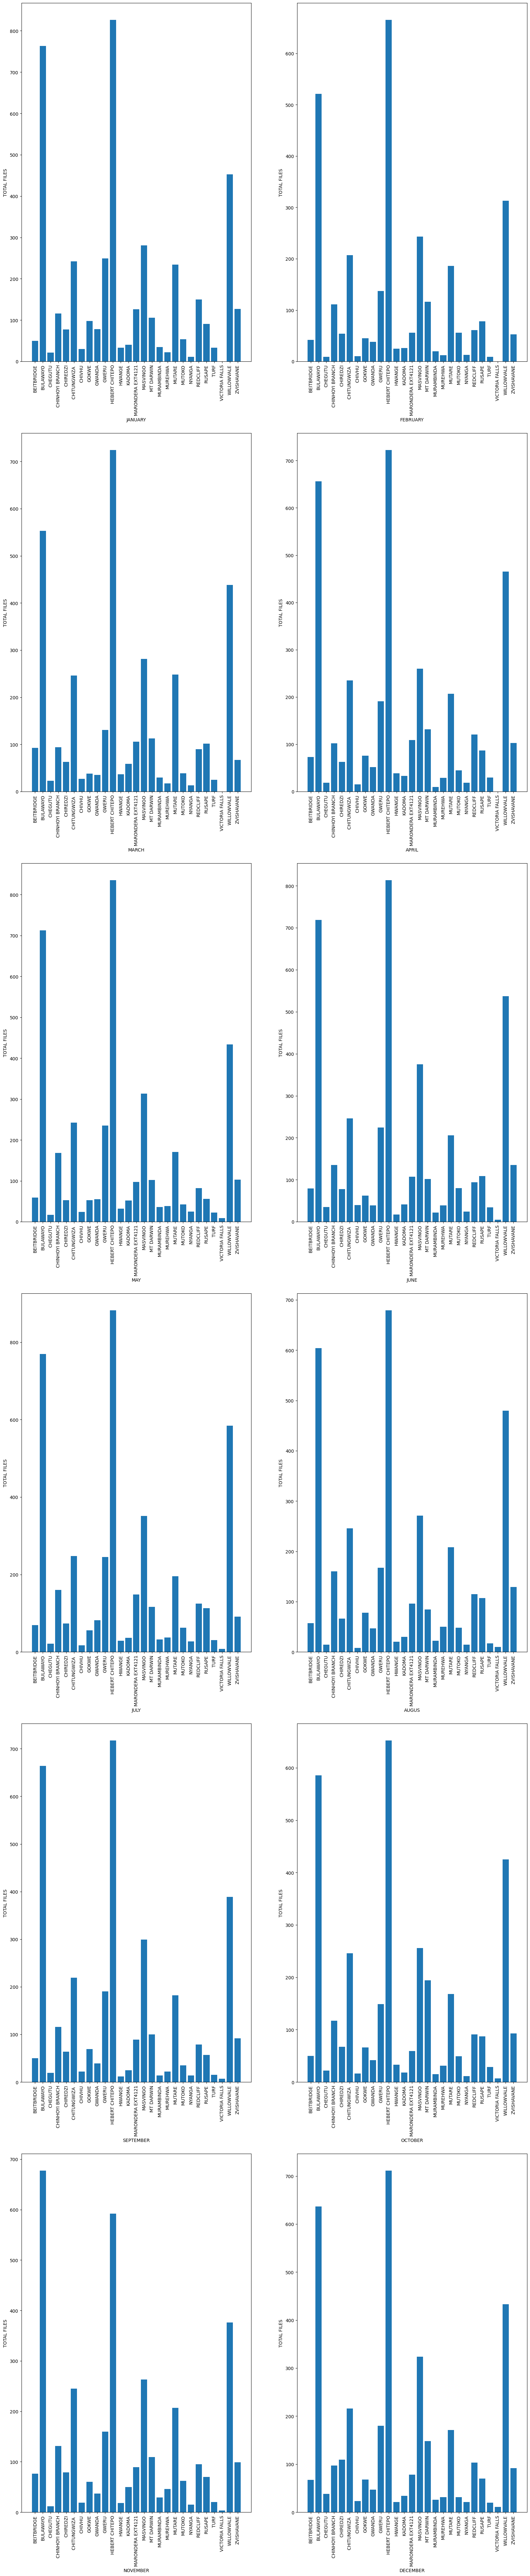

In [70]:
#group the data using month and branch features
gby_mb=data.groupby(["month","branch name"])[["Total files"]].sum()
gby_mb=gby_mb.reset_index()

months=["JANUARY","FEBRUARY","MARCH","APRIL","MAY","JUNE","JULY","AUGUS","SEPTEMBER","OCTOBER","NOVEMBER","DECEMBER"]

# Generate a bar plots for total files for each month per branch
plt.figure(figsize = [20, 100])

# PLOT ON LEFT - counts
plt.subplot(6, 2, 1)
p_month=gby_mb.query("month==1")
x=p_month["branch name"]
y=p_month["Total files"]
plt.bar(x,y)
plt.xlabel(months[0])
plt.ylabel("TOTAL FILES")
plt.xticks(rotation=90)


plt.subplot(6, 2, 2)
p_month=gby_mb.query("month==2")
x=p_month["branch name"]
y=p_month["Total files"]
plt.bar(x,y)
plt.xlabel(months[1])
plt.ylabel("TOTAL FILES")
plt.xticks(rotation=90)

plt.subplot(6, 2, 3)
p_month=gby_mb.query("month==3")
x=p_month["branch name"]
y=p_month["Total files"]
plt.bar(x,y)
plt.xlabel(months[2])
plt.ylabel("TOTAL FILES")
plt.xticks(rotation=90)

plt.subplot(6, 2, 4)
p_month=gby_mb.query("month==4")
x=p_month["branch name"]
y=p_month["Total files"]
plt.bar(x,y)
plt.xlabel(months[3])
plt.ylabel("TOTAL FILES")
plt.xticks(rotation=90)

plt.subplot(6, 2, 5)
p_month=gby_mb.query("month==5")
x=p_month["branch name"]
y=p_month["Total files"]
plt.bar(x,y)
plt.xlabel(months[4])
plt.ylabel("TOTAL FILES")
plt.xticks(rotation=90)

plt.subplot(6, 2, 6)
p_month=gby_mb.query("month==6")
x=p_month["branch name"]
y=p_month["Total files"]
plt.bar(x,y)
plt.xlabel(months[5])
plt.ylabel("TOTAL FILES")
plt.xticks(rotation=90)

plt.subplot(6, 2, 7)
p_month=gby_mb.query("month==7")
x=p_month["branch name"]
y=p_month["Total files"]
plt.bar(x,y)
plt.xlabel(months[6])
plt.ylabel("TOTAL FILES")
plt.xticks(rotation=90)

plt.subplot(6, 2, 8)
p_month=gby_mb.query("month==8")
x=p_month["branch name"]
y=p_month["Total files"]
plt.bar(x,y)
plt.xlabel(months[7])
plt.ylabel("TOTAL FILES")
plt.xticks(rotation=90)

plt.subplot(6, 2, 9)
p_month=gby_mb.query("month==9")
x=p_month["branch name"]
y=p_month["Total files"]
plt.bar(x,y)
plt.xlabel(months[8])
plt.ylabel("TOTAL FILES")
plt.xticks(rotation=90)

plt.subplot(6, 2, 10)
p_month=gby_mb.query("month==10")
x=p_month["branch name"]
y=p_month["Total files"]
plt.bar(x,y)
plt.xlabel(months[9])
plt.ylabel("TOTAL FILES")
plt.xticks(rotation=90)

plt.subplot(6, 2, 11)
p_month=gby_mb.query("month==11")
x=p_month["branch name"]
y=p_month["Total files"]
plt.bar(x,y)
plt.xlabel(months[10])
plt.ylabel("TOTAL FILES")
plt.xticks(rotation=90)

plt.subplot(6, 2, 12)
p_month=gby_mb.query("month==12")
x=p_month["branch name"]
y=p_month["Total files"]
plt.bar(x,y)
plt.xlabel(months[11])
plt.ylabel("TOTAL FILES")
plt.xticks(rotation=90)


plt.show()



Looking at the total files received by each branch per month,we can see that there is a uniform distribution of total files per month throughout the year for each branch

In [71]:
gby_b=gby_mb.groupby("branch name")[["Total files"]].mean()
gby_b=gby_b.reset_index()
gby_b=gby_b.sort_values(by="Total files")
gby_b

,branch name,Total files
24,VICTORIA FALLS,5.000000
20,NYANGA,17.250000
2,CHEGUTU,20.833333
6,CHIVHU,20.916667
23,TURF,23.666667
16,MURAMBINDA,24.250000
11,HWANGE,26.333333
17,MUREHWA,31.166667
12,KADOMA,37.000000
8,GWANDA,49.250000


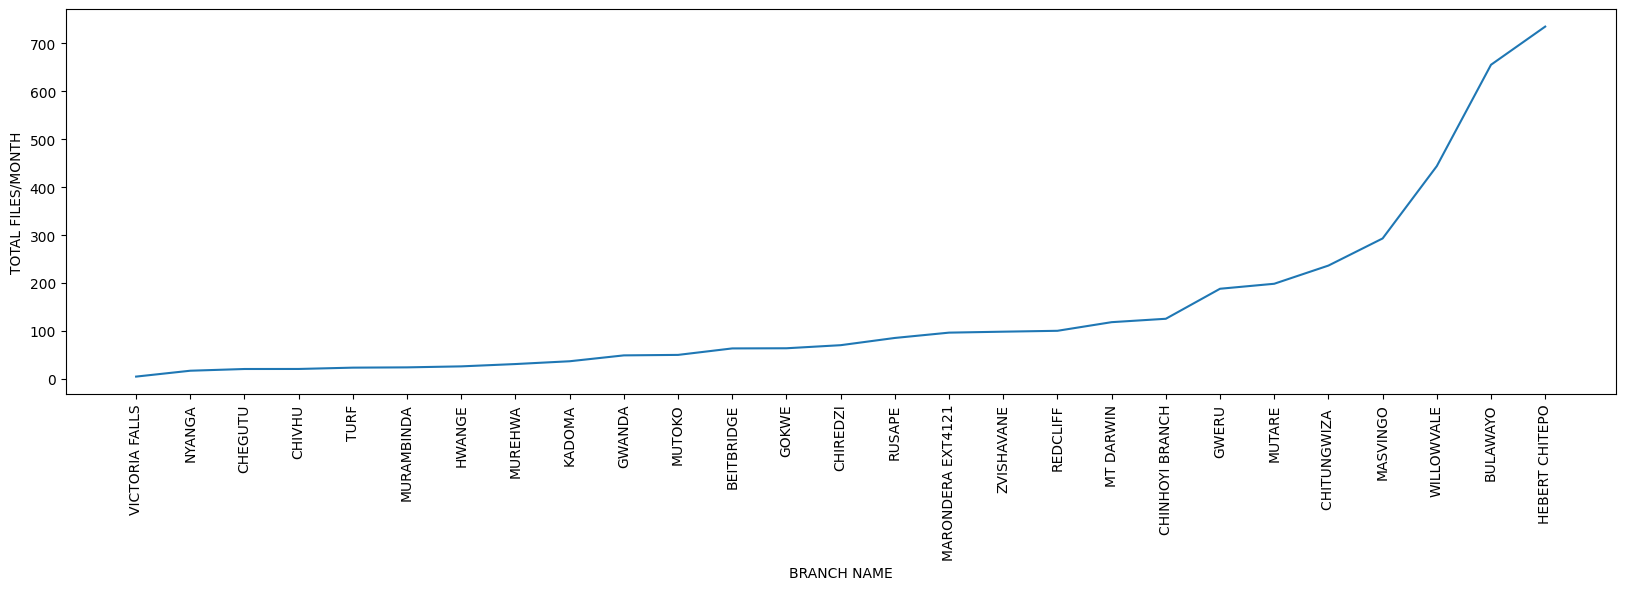

In [89]:
#plot the averagenumber of files received per month for each branch
plt.figure(figsize = [20, 5])
#gby_b.plot(x="branch name",y="Total files")
x=gby_b["branch name"]
y=gby_b["Total files"]
plt.plot(x,y)
plt.xlabel("BRANCH NAME")
plt.ylabel("TOTAL FILES/MONTH")
plt.xticks(rotation=90)
plt.show()

Looking at the total files received by each branch per month,we can see that there is a uniform distribution of total files per month throughout the year for each branch.From the organization's work model, it is said that a consultant have to work five days per week then process 6 files per day which means the consultant has to process 120 files per month thus we can allocate consultants for each branch as follows:

- HEBERT CHITEPO (6)
- BULAWAYO(6)
- WILLOWVALE (4)
- MASVINGO (3)
- CHITUNGWIZA (2)
- MUTARE (2)
- GWERU (2)
- CHINHOYI BRANCH (2)
- MT DARWIN (1)
- REDCLIF (1)
- ZVISHAVANE (1)
- VICTORIA FALLS (1)
- NYANGA (1)
- CHEGUTU (1)
- CHIVHU 	(1)
- TURF (1)
- MURAMBINDA (1)
- HWANGE 	 (1)
- MUREHWA 	(1)
- KADOMA 	(1)
- GWANDA 	(1)
- MUTOKO (1)
- BEITBRIDGE (1)
- GOKWE (1)
- CHIREDZI  (1)
- RUSAPE 	(1)
- MARONDERA EXT412 (1)

In [72]:
#group the data using quarter and branch features
gby_qb=data.groupby(["quarter","branch name"])[["Total files"]].sum()
gby_qb=gby_qb.reset_index()

gby_qb

,quarter,branch name,Total files
0,1,BEITBRIDGE,185
1,1,BULAWAYO,1837
2,1,CHEGUTU,53
3,1,CHINHOYI BRANCH,321
4,1,CHIREDZI,194
...,...,...,...
103,4,RUSAPE,227
104,4,TURF,69
105,4,VICTORIA FALLS,21
106,4,WILLOWVALE,1234


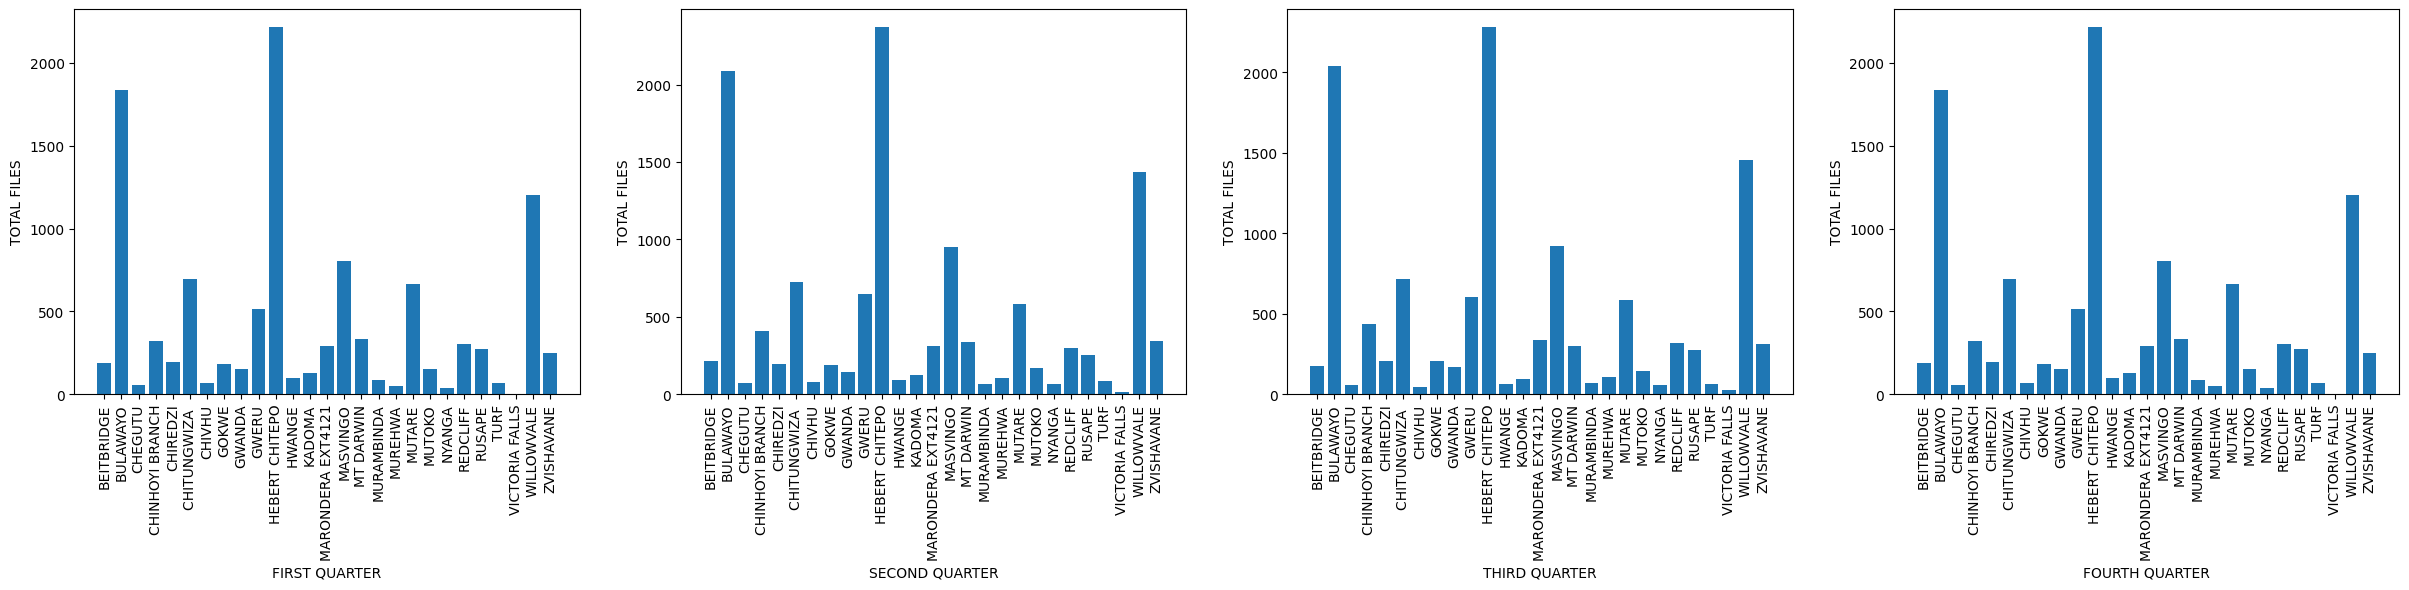

In [73]:

quarters=["FIRST QUARTER","SECOND QUARTER","THIRD QUARTER","FOURTH QUARTER"]

# Generate a bar plots for total files for each quarter per branch
plt.figure(figsize = [30, 5])

# PLOT ON LEFT - counts
plt.subplot(1, 4, 1)
p_month=gby_qb.query("quarter==1")
x=p_month["branch name"]
y=p_month["Total files"]
plt.bar(x,y)
plt.xlabel(quarters[0])
plt.ylabel("TOTAL FILES")
plt.xticks(rotation=90)


plt.subplot(1, 4, 2)
p_month=gby_qb.query("quarter==2")
x=p_month["branch name"]
y=p_month["Total files"]
plt.bar(x,y)
plt.xlabel(quarters[1])
plt.ylabel("TOTAL FILES")
plt.xticks(rotation=90)

plt.subplot(1, 4, 3)
p_month=gby_qb.query("quarter==3")
x=p_month["branch name"]
y=p_month["Total files"]
plt.bar(x,y)
plt.xlabel(quarters[2])
plt.ylabel("TOTAL FILES")
plt.xticks(rotation=90)

plt.subplot(1, 4, 4)
p_month=gby_qb.query("quarter==1")
x=p_month["branch name"]
y=p_month["Total files"]
plt.bar(x,y)
plt.xlabel(quarters[3])
plt.ylabel("TOTAL FILES")
plt.xticks(rotation=90)



plt.show()



In [74]:
data=pd.get_dummies(data)
#data=data.drop(["month","quarter"],axis=1)

data

,month,week of year,quarter,Total files,branch name_BEITBRIDGE,branch name_BULAWAYO,branch name_CHEGUTU,branch name_CHINHOYI BRANCH,branch name_CHIREDZI,branch name_CHITUNGWIZA,...,branch name_MUREHWA,branch name_MUTARE,branch name_MUTOKO,branch name_NYANGA,branch name_REDCLIFF,branch name_RUSAPE,branch name_TURF,branch name_VICTORIA FALLS,branch name_WILLOWVALE,branch name_ZVISHAVANE
0,1,1,1,14,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,200,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,5,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,24,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,15,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67387,12,52,4,17,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
67388,12,52,4,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
67389,12,52,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
67390,12,52,4,76,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [75]:
X,y = data.drop(["Total files"],axis=1),data[["Total files"]]

X_train= X.loc[X.index<=53912]
X_test= X.loc[X.index>=53912]
y_train = y.loc[y.index<=53912]
y_test= y.loc[y.index>=53912]

X_test

,month,week of year,quarter,branch name_BEITBRIDGE,branch name_BULAWAYO,branch name_CHEGUTU,branch name_CHINHOYI BRANCH,branch name_CHIREDZI,branch name_CHITUNGWIZA,branch name_CHIVHU,...,branch name_MUREHWA,branch name_MUTARE,branch name_MUTOKO,branch name_NYANGA,branch name_REDCLIFF,branch name_RUSAPE,branch name_TURF,branch name_VICTORIA FALLS,branch name_WILLOWVALE,branch name_ZVISHAVANE
53912,10,32,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
53913,10,32,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
53914,10,32,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
53915,10,32,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
53916,10,32,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67387,12,52,4,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
67388,12,52,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
67389,12,52,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
67390,12,52,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [76]:
dm_train=xgb.DMatrix(X_train,y_train,enable_categorical=True)
dm_test=xgb.DMatrix(X_test,y_test,enable_categorical=True)

In [77]:
params={"objective":"reg:squarederror"}
n=100

model = xgb.train(params=params,dtrain=dm_train,num_boost_round=n)


In [78]:
pred = model.predict(dm_test)

print(f"MSE :{mean_squared_error(y_test,pred)}")

MSE :93.77218666774168


In [92]:
#datac
df_test=pd.DataFrame({"month":X_test["month"],"branch name":datac.query("index>=53912")["branch name"],
                      "actual":y_test["Total files"],"prediction":pred})

df_test["prediction"]=df_test["prediction"]
df_test=df_test.groupby(["month","branch name"])[["actual","prediction"]].sum()
df_test

actual  prediction
month branch name                        
10    BEITBRIDGE           50   58.223427
      BULAWAYO            586  590.132874
      CHEGUTU              22   47.080070
      CHINHOYI BRANCH     117  107.597801
      CHIREDZI             67   58.223427
...                       ...         ...
12    RUSAPE               70   68.253342
      TURF                 20   46.487095
      VICTORIA FALLS       11   27.217976
      WILLOWVALE          433  247.663483
      ZVISHAVANE           92   83.958832

[81 rows x 2 columns]

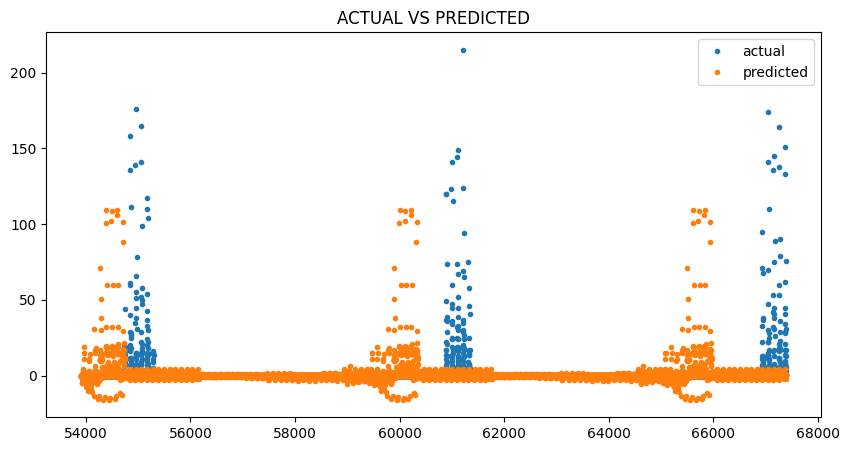

In [62]:
#ax=X_test[["week of year"]].plot(figsize=(15,5))
fugure,ax=plt.subplots(figsize=(10,5))
df_test["actual"].plot(ax=ax,style=".")
df_test["prediction"].plot(ax=ax,style=".")
plt.legend(["actual","predicted"])
ax.set_title("ACTUAL VS PREDICTED")
plt.show()


In [ ]:
submission=data.groupby(["month","week of year","branch name"])["Total files"].sum()
submission

# EXPLORE THE FILE_AGEING.CSV FILE

In [ ]:
#view the dataset structure
data4

,file_date_in,file_date_out,file_id,consultant_fullname,branch name
0,1/1/2022 3:00,2/1/2022 16:59,20653,MUNYARADZI NYAMAROPA,BEITBRIDGE
1,1/1/2022 5:00,1/1/2022 16:59,20638,MILDRED CHAPUNGU,BEITBRIDGE
2,2/1/2022 2:30,2/1/2022 5:00,20712,MILDRED CHAPUNGU,BEITBRIDGE
3,2/1/2022 4:00,2/1/2022 16:59,20737,MILDRED CHAPUNGU,BEITBRIDGE
4,3/1/2022 10:20,5/1/2022 16:00,20830,EANEST RUKASHA,BEITBRIDGE
...,...,...,...,...,...
18927,27/12/2022 18:30:00,28/12/2022 16:00:00,44329,CHIDOCHASHE MUGOZHI,ZVISHAVANE
18928,28/12/2022 13:30:00,31/12/2022 15:00:00,44405,CHIDOCHASHE MUGOZHI,ZVISHAVANE
18929,29/12/2022 11:33:00,30/12/2022 16:00:00,44455,CHIDOCHASHE MUGOZHI,ZVISHAVANE
18930,29/12/2022 22:34:00,30/12/2022 16:00:00,44499,CHIDOCHASHE MUGOZHI,ZVISHAVANE


In [ ]:
#convert the string date columns to datetime objects
data4["file_date_in"]=pd.to_datetime(data4["file_date_in"])
data4["file_date_out"]=pd.to_datetime(data4["file_date_out"])


data4

,file_date_in,file_date_out,file_id,consultant_fullname,branch name
0,2022-01-01 03:00:00,2022-02-01 16:59:00,20653,MUNYARADZI NYAMAROPA,BEITBRIDGE
1,2022-01-01 05:00:00,2022-01-01 16:59:00,20638,MILDRED CHAPUNGU,BEITBRIDGE
2,2022-02-01 02:30:00,2022-02-01 05:00:00,20712,MILDRED CHAPUNGU,BEITBRIDGE
3,2022-02-01 04:00:00,2022-02-01 16:59:00,20737,MILDRED CHAPUNGU,BEITBRIDGE
4,2022-03-01 10:20:00,2022-05-01 16:00:00,20830,EANEST RUKASHA,BEITBRIDGE
...,...,...,...,...,...
18927,2022-12-27 18:30:00,2022-12-28 16:00:00,44329,CHIDOCHASHE MUGOZHI,ZVISHAVANE
18928,2022-12-28 13:30:00,2022-12-31 15:00:00,44405,CHIDOCHASHE MUGOZHI,ZVISHAVANE
18929,2022-12-29 11:33:00,2022-12-30 16:00:00,44455,CHIDOCHASHE MUGOZHI,ZVISHAVANE
18930,2022-12-29 22:34:00,2022-12-30 16:00:00,44499,CHIDOCHASHE MUGOZHI,ZVISHAVANE


In [ ]:
#calculate the time taken for the consultant to close a file
data4["time_taken"] = data4["file_date_out"].sub(data4["file_date_in"])
data4

,file_date_in,file_date_out,file_id,consultant_fullname,branch name,time_taken
0,2022-01-01 03:00:00,2022-02-01 16:59:00,20653,MUNYARADZI NYAMAROPA,BEITBRIDGE,31 days 13:59:00
1,2022-01-01 05:00:00,2022-01-01 16:59:00,20638,MILDRED CHAPUNGU,BEITBRIDGE,0 days 11:59:00
2,2022-02-01 02:30:00,2022-02-01 05:00:00,20712,MILDRED CHAPUNGU,BEITBRIDGE,0 days 02:30:00
3,2022-02-01 04:00:00,2022-02-01 16:59:00,20737,MILDRED CHAPUNGU,BEITBRIDGE,0 days 12:59:00
4,2022-03-01 10:20:00,2022-05-01 16:00:00,20830,EANEST RUKASHA,BEITBRIDGE,61 days 05:40:00
...,...,...,...,...,...,...
18927,2022-12-27 18:30:00,2022-12-28 16:00:00,44329,CHIDOCHASHE MUGOZHI,ZVISHAVANE,0 days 21:30:00
18928,2022-12-28 13:30:00,2022-12-31 15:00:00,44405,CHIDOCHASHE MUGOZHI,ZVISHAVANE,3 days 01:30:00
18929,2022-12-29 11:33:00,2022-12-30 16:00:00,44455,CHIDOCHASHE MUGOZHI,ZVISHAVANE,1 days 04:27:00
18930,2022-12-29 22:34:00,2022-12-30 16:00:00,44499,CHIDOCHASHE MUGOZHI,ZVISHAVANE,0 days 17:26:00


In [ ]:
#group the data by branch name and get the average time taken to close the files
gby_b=data4.groupby(["branch name"])["time_taken"].mean()
gby_b

branch name
BEITBRIDGE            3 days 01:03:33.278508771
BULAWAYO              4 days 22:16:07.284525790
CHEGUTU             -2 days +22:43:09.655172414
CHINHOYI BRANCH       5 days 03:42:34.428571428
CHIREDZI              5 days 10:34:51.854271356
CHITUNGWIZA           1 days 01:23:25.410196078
CHIVHU                3 days 01:47:01.966887417
GOKWE                 3 days 15:00:08.659090909
GWANDA              -3 days +16:07:36.128676471
GWERU               -2 days +11:36:52.546275396
HEBERT CHITEPO        3 days 05:05:39.646126760
HWANGE              -1 days +17:57:06.315789474
KADOMA                9 days 15:19:57.391304347
MARONDERA EXT4121     3 days 19:10:12.969348659
MASVINGO            -1 days +17:43:59.315190902
MT DARWIN             3 days 02:21:41.504587155
MURAMBINDA            6 days 03:01:18.025641025
MUREHWA               0 days 14:19:11.428571428
MUTARE                0 days 11:46:02.292442497
MUTOKO              -2 days +14:32:54.368932039
NYANGA                7 days